In [89]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.FeatExtModels_NoKaiser import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

TrRate = 0.8

### Data

In [95]:
DATA = np.load('./Data/AsanTRSet.npy')

np.random.seed(7)
PermutedDATA = np.random.permutation(DATA)
TrLen = int(PermutedDATA.shape[0] * TrRate)

TrData = PermutedDATA[:TrLen]
ValData = PermutedDATA[TrLen:]

#### Env setting

In [3]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
### Model checkpoint
ModelSaveSameName = save_path+'SigBandRepModel_ExtRec.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=500)

LatDim = 3
SigDim = DATA.shape[1]
MaskingRate = 0.02
NoiseStd = 0.002
MaskStd = 0.1
ReparaStd = 0.1

In [ ]:
'''
class RelLossWeight(tf.keras.callbacks.Callback):
    def __init__(self, LossName1, LossName2, BetaName1, BetaName2, verbose=1):
                
        self.LossName1 = LossName1
        self.LossName2 = LossName2
        self.BetaName1 = BetaName1
        self.BetaName2 = BetaName2
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        
        Loss1 = logs[self.LossName1] 
        Loss2 = logs[self.LossName2] 
        
        Beta1_idx = [num for num, i in enumerate(self.model.variables) if self.BetaName1 in i.name][0]
        Beta2_idx = [num for num, i in enumerate(self.model.variables) if self.BetaName2 in i.name][0]
        
        self.model.variables[Beta1_idx].assign(Loss1/Loss2)
        self.model.variables[Beta2_idx].assign(Loss2/Loss1)   

        if self.verbose==1:
            print(self.BetaName1+' : ', self.model.variables[Beta1_idx])
            print(self.BetaName2+' : ', self.model.variables[Beta2_idx])        
 

# Define the KL annealing callback function
class KLCallback(tf.keras.callbacks.Callback):
    def __init__(self, TargetLossName, Threshold, MaxBeta, BetaName, AnnealEpoch=100):
        self.TargetLossName = TargetLossName
        self.Threshold = Threshold
        self.BetaName = BetaName
        self.MaxBeta = MaxBeta
        self.AnnealStart = 0
        self.AnnealEpoch = AnnealEpoch

    def on_epoch_end(self, epoch, logs={}):
        
        TargetLoss = logs['val_'+self.TargetLossName]
        
        if TargetLoss > self.Threshold:
            
            self.AnnealStart = 0
            K.set_value(self.model.get_layer(self.BetaName).variables[0], 0.)
        else: 
            self.AnnealStart += 1
            Beta = (self.AnnealStart) / self.AnnealEpoch * self.MaxBeta
            K.set_value(self.model.get_layer(self.BetaName).variables[0], Beta)
        
        print(self.model.get_layer(self.BetaName).variables[0])
'''

'''
class KLAnneal(tf.keras.callbacks.Callback):
    def __init__(self, TargetLossName, Threshold,  BetaName, MaxBeta=0.1, MinBeta=1e-5, AnnealEpoch=100, UnderLimit=0., verbose=1):
        
        if type(TargetLossName) != list:
            TargetLossName = [TargetLossName]
        
        self.TargetLossName = TargetLossName
        self.Threshold = Threshold
        self.BetaName = BetaName
        self.AnnealIdx = 0
        self.verbose = verbose 
        self.Beta =  np.concatenate([np.array([UnderLimit]), np.linspace(start=MinBeta, stop=MaxBeta, num=AnnealEpoch )])

    def on_epoch_end(self, epoch, logs={}):
        
        TargetLoss = max([logs[i] for i in self.TargetLossName]) 
        
        if TargetLoss > self.Threshold:
            
            #self.AnnealIdx -= 1
            #self.AnnealIdx = np.maximum(self.AnnealIdx, 0)
            K.set_value(self.model.get_layer(self.BetaName).variables[0], self.Beta[self.AnnealIdx])
        else: 
            self.AnnealIdx += 1
            self.AnnealIdx = np.minimum(self.AnnealIdx, len(self.Beta)-1)
            K.set_value(self.model.get_layer(self.BetaName).variables[0], self.Beta[self.AnnealIdx])
        
        if self.verbose==1:
            print(self.BetaName+' : ' ,self.model.get_layer(self.BetaName).variables[0].numpy())
        elif self.verbose==2:
            print('TargetLoss : ', TargetLoss)
            print(self.BetaName+' : ' ,self.model.get_layer(self.BetaName).variables[0].numpy())
'''

'''
class RelLossWeight(tf.keras.callbacks.Callback):
    def __init__(self, LossName1, LossName2, Beta1, Beta2, WeightB1 =1., WeightB2 =1., BetaName1 ='Beta1' , BetaName2 ='Beta2' , verbose=1):
                
        self.LossName1 = LossName1
        self.LossName2 = LossName2
        self.Beta1 = Beta1
        self.Beta2 = Beta2
        self.BetaName1 = BetaName1
        self.BetaName2 = BetaName2
        self.verbose = verbose
        self.WeightB1 = WeightB1
        self.WeightB2 = WeightB2

    def on_epoch_end(self, epoch, logs={}):
        
        Loss1 = logs[self.LossName1] 
        Loss2 = logs[self.LossName2] 
        
        Beta1 = tf.maximum(Loss1/Loss2, 1.) * self.WeightB1
        Beta2 = tf.maximum(Loss2/Loss1, 1.) * self.WeightB2
        
        self.Beta1.assign(Beta1)
        self.Beta2.assign(Beta2)   

        if self.verbose==1:
            print(self.BetaName1+' : ', self.Beta1.numpy())
            print(self.BetaName2+' : ', self.Beta2.numpy())   
'''

In [ ]:
'''
class KLAnneal(tf.keras.callbacks.Callback):
    def __init__(self, TargetLossName, Threshold,  Beta, BetaName ='Beta', MaxBeta=0.1, MinBeta=1e-5, AnnealEpoch=100, UnderLimit=0., verbose=1):
        
        if type(TargetLossName) != list:
            TargetLossName = [TargetLossName]
        
        self.TargetLossName = TargetLossName
        self.Threshold = Threshold
        self.Beta = Beta
        self.BetaName = BetaName
        self.AnnealIdx = 0
        self.verbose = verbose 
        self.BetaValue =  np.concatenate([np.array([UnderLimit]), np.linspace(start=MinBeta, stop=MaxBeta, num=AnnealEpoch )])

    def on_epoch_end(self, epoch, logs={}):
        
        TargetLoss = max([logs[i] for i in self.TargetLossName]) 
        
        if TargetLoss > self.Threshold:
            
            #self.AnnealIdx -= 1
            #self.AnnealIdx = np.maximum(self.AnnealIdx, 0)
            self.Beta.assign(self.BetaValue[self.AnnealIdx])
        else: 
            self.AnnealIdx += 1
            self.AnnealIdx = np.minimum(self.AnnealIdx, len(self.BetaValue)-1)
            self.Beta.assign(self.BetaValue[self.AnnealIdx])
        
        if self.verbose==1:
            print(self.BetaName+' : ' ,self.Beta.numpy())
        elif self.verbose==2:
            print('TargetLoss : ', TargetLoss)
            print(self.BetaName+' : ' ,self.Beta.numpy())
            
            
       
class RelLossWeight(tf.keras.callbacks.Callback):
    def __init__(self, BetaList, BetaWeight, MinLimit , MaxLimit , verbose=1):
                
        self.BetaList = BetaList
        self.BetaWeight = BetaWeight
        self.MinLimit = MinLimit
        self.MaxLimit = MaxLimit
        self.verbose = verbose

        
    def on_epoch_end(self, epoch, logs={}):
        
        Losses = np.array([logs[i] for i in self.BetaList.keys()])
        Losses = np.maximum(1e-7, Losses)
        RelWeights = Losses / np.min(Losses)
        RelWeights = {LossName:RelWeights[num] for num, LossName in enumerate (self.BetaList.keys())}

        for name, beta in self.BetaList.items():
            
            Value = np.clip(RelWeights[name] * self.BetaWeight[name], self.MinLimit[name], self.MaxLimit[name])
            beta.assign(Value)

        if self.verbose==1:
            print(RelWeights)
            for key, beta in self.BetaList.items():
                print(key, ': ', beta.numpy())
                
RelLossDic = {'val_mse':'Beta_Rec', 'val_FeatRecLoss':'Beta_Feat', 'val_kl_Loss_Z':'Beta_Z', 'val_kl_Loss_FC':'Beta_Fc'}
WeightDic = {'val_mse':10., 'val_FeatRecLoss':100., 'val_kl_Loss_Z':1., 'val_kl_Loss_FC':1.}
MinLimit = {'val_mse':1., 'val_FeatRecLoss':1., 'val_kl_Loss_Z':0.01, 'val_kl_Loss_FC':0.01}
MaxLimit = {'val_mse':200., 'val_FeatRecLoss':200., 'val_kl_Loss_Z':0.1, 'val_kl_Loss_FC':0.1}
RelLoss = RelLossWeight(BetaList=RelLossDic, BetaWeight= WeightDic, MinLimit= MinLimit, MaxLimit = MaxLimit )


class RelLossWeight(tf.keras.callbacks.Callback):
    def __init__(self, BetaList, LossScaling, MinLimit , MaxLimit , verbose=1):
                
        self.BetaList = BetaList
        self.LossScaling = LossScaling
        self.MinLimit = MinLimit
        self.MaxLimit = MaxLimit
        self.verbose = verbose

        
    def on_epoch_end(self, epoch, logs={}):
        
        Losses = np.array([logs[i] for i in self.BetaList.keys()])
        Losses = np.maximum(1e-7, Losses)
        RelWeights = Losses / np.min(Losses)
        RelWeights = {loss:RelWeights[num] * self.LossScaling[loss] for num, loss in enumerate (self.BetaList.keys())}

        for loss, beta in self.BetaList.items():
            
            Value = np.clip(RelWeights[loss] , self.MinLimit[beta], self.MaxLimit[beta])
            K.set_value(self.model.get_layer(beta).variables[0], Value)

        if self.verbose==1:
            print('RelWeights')
            print(RelWeights)
                       
            for key, beta in self.BetaList.items():
                print(beta, ': ', self.model.get_layer(beta).variables[0].numpy())

'''        


In [4]:
        
def ReName (layer, name):
    return Lambda(lambda x: x, name=name)(layer)

def ParaFilters (layer, name=''):
    Fc = Dense(1, activation='sigmoid')(layer)
    Fc = tf.clip_by_value(Fc, 1e-7, 1-1e-7)
    
    # Reparameterization Trick for sampling from Uniformly distribution; ϵ∼U(0,1) 
    Epsilon = tf.random.uniform(shape=(tf.shape(Fc)[0], Fc.shape[1]))
    Epsilon = tf.clip_by_value(Epsilon, 1e-7, 1-1e-7)

    LogEps = tf.math.log(Epsilon)
    LogNegEps = tf.math.log(1 - Epsilon)
    
    LogTheta = tf.math.log(Fc)
    LogNegTheta = tf.math.log(1-Fc)

    Fc = tf.math.sigmoid(LogEps - LogNegEps + LogTheta - LogNegTheta)
    Fc = tf.clip_by_value(Fc, 1e-7, 1-1e-7)
    Fc = ReName(Fc, name)
    
    return Fc 


class Lossweight(tf.keras.layers.Layer):
    
    def __init__(self, InitVal = 0., name='Lossweight'):
        super(Lossweight, self).__init__(name=name)
        self.InitVal = InitVal
    
    def build(self, input_shape):
        self.GenVec = tf.Variable(self.InitVal, trainable=False)
    
    def call(self, input):

        return self.GenVec
    
    def get_config(self):
        config = super(Lossweight, self).get_config()
        config.update({ 'InitVal': self.InitVal })
        return config
    

class RandFCs(tf.keras.layers.Layer):
    
    def __init__(self, ):
        super(RandFCs, self).__init__(name='FCs')
        pass
    
    def build(self, input_shape):
        self.GenVec = tf.Variable(tf.random.uniform(shape=(1,6)), trainable=False)
    
    def call(self, input):
        return tf.tile(self.GenVec , (tf.shape(input)[0],1))
    


class KLAnneal(tf.keras.callbacks.Callback):
    def __init__(self, TargetLossName, Threshold,  BetaName, MaxBeta=0.1, MinBeta=1e-5, AnnealEpoch=100, UnderLimit=0., verbose=1):
        
        if type(TargetLossName) != list:
            TargetLossName = [TargetLossName]
        
        self.TargetLossName = TargetLossName
        self.Threshold = Threshold
        self.BetaName = BetaName
        self.AnnealIdx = 0
        self.verbose = verbose 
        self.Beta =  np.concatenate([np.array([UnderLimit]), np.linspace(start=MinBeta, stop=MaxBeta, num=AnnealEpoch )])

    def on_epoch_end(self, epoch, logs={}):
        
        TargetLoss = max([logs[i] for i in self.TargetLossName]) 
        
        if TargetLoss > self.Threshold:
            
            self.AnnealIdx -= 1
            self.AnnealIdx = np.maximum(self.AnnealIdx, 0)
            K.set_value(self.model.get_layer(self.BetaName).variables[0], self.Beta[self.AnnealIdx])
        else: 
            self.AnnealIdx += 1
            self.AnnealIdx = np.minimum(self.AnnealIdx, len(self.Beta)-1)
            K.set_value(self.model.get_layer(self.BetaName).variables[0], self.Beta[self.AnnealIdx])
        
        if self.verbose==1:
            print(self.BetaName+' : ' ,self.model.get_layer(self.BetaName).variables[0].numpy())
        elif self.verbose==2:
            print('TargetLoss : ', TargetLoss)
            print(self.BetaName+' : ' ,self.model.get_layer(self.BetaName).variables[0].numpy())
            
          

class RelLossWeight(tf.keras.callbacks.Callback):
    def __init__(self, BetaList, LossScaling, MinLimit , MaxLimit , verbose=1, ToSaveLoss=None, SavePath=None):
                
        self.BetaList = BetaList
        self.LossScaling = LossScaling
        self.MinLimit = MinLimit
        self.MaxLimit = MaxLimit
        self.verbose = verbose
        self.ToSaveLoss = ToSaveLoss
        self.CheckLoss = np.inf
        self.SavePath = SavePath

        
    def on_epoch_end(self, epoch, logs={}):
        
        Losses = {key:logs[key]/np.maximum(1e-7,self.model.get_layer(beta).variables[0].numpy()) for key, beta in self.BetaList.items()}

        if self.ToSaveLoss is not None:
            beta = self.BetaList[self.ToSaveLoss]
            CurrentLoss = logs[self.ToSaveLoss]/np.maximum(1e-7,self.model.get_layer(beta).variables[0].numpy())
            
            if CurrentLoss <= self.CheckLoss:
                self.model.save(self.SavePath)
                print()
                print('the model has been saved since loss has decreased from '+ str(self.CheckLoss)+ ' to ' + str(CurrentLoss))
                print()
                self.CheckLoss = CurrentLoss
            else:
                print('the model has not been saved since the loss has not decreased from '+ str(self.CheckLoss))
                
                
        WeigLosses = np.maximum(1e-7, np.array(list(Losses.values())))
        #print(WeigLosses)
        RelWeights = WeigLosses / np.min(WeigLosses)
        #print(RelWeights)
        RelWeights = {loss:RelWeights[num] * self.LossScaling[loss] for num, loss in enumerate (self.BetaList.keys())}
        #print(RelWeights)

        for loss, beta in self.BetaList.items():
            
            Value = np.clip(RelWeights[loss] , self.MinLimit[beta], self.MaxLimit[beta])
            K.set_value(self.model.get_layer(beta).variables[0], Value)

        if self.verbose==1:

            print('------------------------------------')
            print('Losses')
            for key, value in Losses.items():
                print("%s: %.7f" % (key, value))
            
            print('------------------------------------')
            print('RelWeights')
            for key, value in RelWeights.items():
                print("%s: %.7f" % (key, value))

            print('------------------------------------')
            print('Beta')
            for key, beta in self.BetaList.items():
                print(beta, ': ', self.model.get_layer(beta).variables[0].numpy())
            print('------------------------------------')
            print()

In [75]:
def Encoder(SigDim, LatDim= 2, Type = '', MaskingRate = 0.025, NoiseStd = 0.002, MaskStd = 0.1, ReparaStd = 0.1 , Reparam = False):

    InpL = Input(shape=(SigDim,))
    InpFrame = tf.signal.frame(InpL, 100, 100)

    if Reparam:
        InpRegul = GaussianNoise(stddev=NoiseStd)(InpFrame, training=Reparam)
        MaskVec, NoisVec = MaskingGen(InpRegul, MaskingRate, MaskStd)
        EncInp = Masking(mask_value=0.)(InpRegul * MaskVec )
        EncOut = InpRegul + NoisVec
    else:
        EncInp, EncOut = InpFrame, InpFrame

    Encoder = Dense(50, activation='relu')(InpFrame)
    Encoder = Bidirectional(GRU(30, return_sequences=True))(Encoder)
    Encoder = Bidirectional(GRU(30, return_sequences=False))(Encoder)
    Encoder = Dense(50, activation='relu')(Encoder)
    Encoder = Dense(30, activation='relu')(Encoder)
    Encoder = Dense(15, activation='relu')(Encoder)

    Z_Mean = Dense(LatDim, activation='linear')(Encoder)
    Z_Log_Sigma = Dense(LatDim, activation='relu')(Encoder)
    Z_Log_Sigma = ReName(Z_Log_Sigma,'Z_Log_Sigma'+Type)

    
    # Reparameterization Trick for sampling from Guassian distribution
    Epsilon = tf.random.normal(shape=(tf.shape(Z_Mean)[0], Z_Mean.shape[1]), mean=0., stddev=ReparaStd)

    if Reparam==False:
        Epsilon = Epsilon * 0

    Z_Mean = Z_Mean + tf.exp(0.5 * Z_Log_Sigma) * Epsilon
    Z_Mean = ReName(Z_Mean,'Z_Mean'+Type)
    
    FCs =   Dense(6, activation='relu')(Encoder)
    FCs =   Dense(6, activation='sigmoid')(FCs)
    
    
    # Reparameterization Trick for sampling from Uniformly distribution; ϵ∼U(0,1) 
    FCs = tf.clip_by_value(FCs, 1e-7, 1-1e-7)
    Epsilon = tf.random.uniform(shape=(tf.shape(FCs)[0], FCs.shape[1]))
    Epsilon = tf.clip_by_value(Epsilon, 1e-7, 1-1e-7)
    
    LogEps = tf.math.log(Epsilon)
    LogNegEps = tf.math.log(1 - Epsilon)
    
    LogTheta = tf.math.log(FCs)
    LogNegTheta = tf.math.log(1-FCs)
    
    if Reparam==True:
        FCs = tf.math.sigmoid(LogEps - LogNegEps + LogTheta - LogNegTheta)
    
    FCs = tf.clip_by_value(FCs, 1e-7, 1-1e-7)
    FCs = ReName(FCs, 'FCs')
    
    return [InpL], [Flatten(name='SigOut')(EncOut), Z_Mean, FCs]



def FeatExtractor(Inps, LatDim= 2, FiltLenList = [301, 301, 301, 301, 301, 301] ):
    
    EncReInp, InpZ, FCs = Inps
    
    H_F, L_F, HH_F, HL_F, LH_F, LL_F = tf.split(FCs, 6, axis=1)
    

    ### Filtering level 1 -------------------------------------------------------------------
    ## Filter generation
    To_H = GenHighFilter(H_F,  N=FiltLenList[0])
    To_L = GenLowFilter(L_F, N=FiltLenList[1])

    ## Perform signal filtering level 1
    InpFrame =  tf.signal.frame(EncReInp, To_H.shape[-1], 1)
    Sig_H = tf.reduce_sum(InpFrame*To_H[:,:,::-1], axis=-1, keepdims=True)
    Sig_H = ReName(Sig_H, 'Sig_H_Ext')

    InpFrame =  tf.signal.frame(EncReInp, To_L.shape[-1], 1)
    Sig_L = tf.reduce_sum(InpFrame*To_L[:,:,::-1], axis=-1, keepdims=True)
    Sig_L = ReName(Sig_L, 'Sig_L_Ext')



    ### Filtering level HH and HL (from Sig_H) -------------------------------------------------------------------
    ## Filter generation
    To_HH = GenHighFilter(HH_F, N=FiltLenList[2])
    To_HL = GenLowFilter(HL_F, N=FiltLenList[3])

    ## Perform signal filtering level 2
    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HH.shape[-1], 1)
    Sig_HH = tf.reduce_sum(Frame_H*To_HH[:,:,::-1], axis=-1, keepdims=True)
    #Sig_HH = ReName(Sig_HH, 'Sig_HH_Ext')

    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HL.shape[-1], 1)
    Sig_HL = tf.reduce_sum(Frame_H*To_HL[:,:,::-1], axis=-1, keepdims=True)
    #Sig_HL = ReName(Sig_HL, 'Sig_HL_Ext')


    ### Filtering level LH and LL (from Sig_L) -------------------------------------------------------------------
    ## Filter generation
    To_LH = GenHighFilter(LH_F,  N=FiltLenList[4])
    To_LL = GenLowFilter(LL_F,  N=FiltLenList[5])

    ## Perform signal filtering level 2
    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LH.shape[-1], 1)
    Sig_LH = tf.reduce_sum(Frame_L*To_LH[:,:,::-1], axis=-1, keepdims=True)
    #Sig_LH = ReName(Sig_LH, 'Sig_LH_Ext')

    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LL.shape[-1], 1)
    Sig_LL = tf.reduce_sum(Frame_L*To_LL[:,:,::-1], axis=-1, keepdims=True)
    #Sig_LL = ReName(Sig_LL, 'Sig_LL_Ext')

    
    return [Flatten(name='Sig_HH_Ext')(Sig_HH), Flatten(name='Sig_HL_Ext')(Sig_HL), Flatten(name='Sig_LH_Ext')(Sig_LH), Flatten(name='Sig_LL_Ext')(Sig_LL)]




def FeatGenerator (Inp_lat):
    
    #Inp_lat = tf.concat(Inp_lat, axis=-1)
    Inp_lat = ReName(Inp_lat, 'Inp_lat')
    InpZ, FCCommon, FCEach = Inp_lat
    HH_F, HL_F, LH_F, LL_F = tf.split(FCEach, 4, axis=1)
    
   
    Dec_Sig_HH = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, HH_F], axis=-1))
    Dec_Sig_HH = Dense(20, activation='relu')(Dec_Sig_HH)
    Dec_Sig_HH = Dense(30, activation='relu')(Dec_Sig_HH)
    Dec_Sig_HH = Dense(50, activation='relu')(Dec_Sig_HH)

    Dec_Sig_HH = RepeatVector(10 )(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_HH)
    Dec_Sig_HH = Dense(40,'tanh')(Dec_Sig_HH)
    Sig_HH= Flatten(name='Sig_HH_Gen')(Dec_Sig_HH)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_HL = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, HL_F], axis=-1))
    Dec_Sig_HL = Dense(20, activation='relu')(Dec_Sig_HL)
    Dec_Sig_HL = Dense(30, activation='relu')(Dec_Sig_HL)
    Dec_Sig_HL = Dense(50, activation='relu')(Dec_Sig_HL)

    Dec_Sig_HL = RepeatVector(10 )(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_HL)
    Dec_Sig_HL = Dense(40,'tanh')(Dec_Sig_HL)
    Sig_HL= Flatten(name='Sig_HL_Gen')(Dec_Sig_HL)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_LH = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, LH_F], axis=-1))
    Dec_Sig_LH = Dense(20, activation='relu')(Dec_Sig_LH)
    Dec_Sig_LH = Dense(30, activation='relu')(Dec_Sig_LH)
    Dec_Sig_LH = Dense(50, activation='relu')(Dec_Sig_LH)

    Dec_Sig_LH = RepeatVector(10 )(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_LH)
    Dec_Sig_LH = Dense(40,'tanh')(Dec_Sig_LH)
    Sig_LH= Flatten(name='Sig_LH_Gen')(Dec_Sig_LH)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_LL = Dense(10, activation='relu')(tf.concat([InpZ, FCCommon, LL_F], axis=-1))
    Dec_Sig_LL = Dense(20, activation='relu')(Dec_Sig_LL)
    Dec_Sig_LL = Dense(30, activation='relu')(Dec_Sig_LL)
    Dec_Sig_LL = Dense(50, activation='relu')(Dec_Sig_LL)

    Dec_Sig_LL = RepeatVector(10 )(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_LL)
    Dec_Sig_LL = Dense(40,'tanh')(Dec_Sig_LL)
    Sig_LL= Flatten(name='Sig_LL_Gen')(Dec_Sig_LL)
    
    return  Sig_HH, Sig_HL, Sig_LH, Sig_LL




def Reconstructor(Inps ):
    Sig_HH, Sig_HL, Sig_LH, Sig_LL = Inps[0]
    FCs = Inps[1][0] 

    ## GRU NET -------------------------------------------------------------------
    Dec_Sig_HH = Reshape((-1, 100))(Sig_HH)
    Dec_Sig_HL = Reshape((-1, 100))(Sig_HL)
    Dec_Sig_LH = Reshape((-1, 100))(Sig_LH)
    Dec_Sig_LL = Reshape((-1, 100))(Sig_LL)

    Dec_Sig_HH = Bidirectional(GRU(5), name='Dec_Sig_HH')(Dec_Sig_HH)
    Dec_Sig_HL = Bidirectional(GRU(5), name='Dec_Sig_HL')(Dec_Sig_HL)
    Dec_Sig_LH = Bidirectional(GRU(5), name='Dec_Sig_LH')(Dec_Sig_LH)
    Dec_Sig_LL = Bidirectional(GRU(5), name='Dec_Sig_LL')(Dec_Sig_LL)

    Decoder = tf.concat([ Dec_Sig_HH, Dec_Sig_HL, Dec_Sig_LH, Dec_Sig_LL, FCs], axis=1)
    Decoder = RepeatVector((SigDim//100) )(Decoder)
    Decoder = Bidirectional(GRU(50, return_sequences=True))(Decoder)
    Decoder = Dense(100, activation='relu')(Decoder)
    DecOut = Dense(100, activation='sigmoid')(Decoder)
    DecOut = Reshape((SigDim,),name='Out')(DecOut)

    
    return DecOut

In [79]:
### Encoder - FeatExtractor
EncInp, EncOut = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=True)
FeatExtOut = FeatExtractor(EncOut)

### Encoder - FeatGenerator - Reconstruction
FeatGenOut = FeatGenerator([EncOut[1],EncOut[2][:, :2], EncOut[2][:, 2:]])
FeatGenOut = ReName(FeatGenOut, 'FeatGenOut')

ReconOut = Reconstructor([FeatExtOut, EncOut[2:]])
ReconOut = ReName(ReconOut, 'ReconOut')

### Define the total model
SigBandRepModel = Model(EncInp, ReconOut)

### Weight controller; Apply beta and capacity 
Capacity_Z = 0.1 # 0.1 0.05
Capacity_Fc = 0.6
Beta_Z = Lossweight(name='Beta_Z')(FeatGenOut)
Beta_Fc = Lossweight(name='Beta_Fc')(FeatGenOut)
Beta_Rec = Lossweight(name='Beta_Rec', InitVal=500.)(FeatGenOut)
Beta_Feat = Lossweight(name='Beta_Feat', InitVal=500.)(FeatGenOut)


### Adding the RecLoss; 
MSE = tf.keras.losses.MeanSquaredError()
RecLoss = Beta_Rec * MSE(ReconOut, EncInp)
SigBandRepModel.add_loss(RecLoss)
SigBandRepModel.add_metric(RecLoss, 'RecLoss')


### Adding the FeatRecLoss; It allows connection between the extractor and generator
FeatRecLoss= Beta_Feat * MSE(tf.concat(FeatGenOut, axis=-1), tf.concat(FeatExtOut, axis=-1))
SigBandRepModel.add_loss(FeatRecLoss)
SigBandRepModel.add_metric(FeatRecLoss, 'FeatRecLoss')

### KL Divergence for p(Z) vs q(Z)
Z_Sampled, Z_Log_Sigma = SigBandRepModel.get_layer('Z_Mean').output, SigBandRepModel.get_layer('Z_Log_Sigma').output
kl_Loss_Z = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss_Z = tf.reduce_mean(kl_Loss_Z )
kl_Loss_Z = Beta_Z * tf.abs(kl_Loss_Z - Capacity_Z)

### KL Divergence for p(FCs) vs q(FCs)
BernP = 0.5 # hyperparameter
FCs = SigBandRepModel.get_layer('FCs').output
kl_Loss_FC = tf.math.log(FCs) - tf.math.log(BernP) + tf.math.log(1-FCs) - tf.math.log(1-BernP) 
kl_Loss_FC = tf.reduce_mean(-kl_Loss_FC )
kl_Loss_FC = Beta_Fc * tf.abs(kl_Loss_FC - Capacity_Fc)

SigBandRepModel.add_loss(kl_Loss_Z )
SigBandRepModel.add_metric(kl_Loss_Z , 'kl_Loss_Z')

SigBandRepModel.add_loss(kl_Loss_FC )
SigBandRepModel.add_metric(kl_Loss_FC , 'kl_Loss_FC')

## Model Compile
SigBandRepModel.compile(optimizer='adam') 

### Loss and KLD_Beta controller
KLD_Beta_Z = KLAnneal(TargetLossName=['val_FeatRecLoss', 'val_RecLoss'], Threshold=0.001, BetaName='Beta_Z',  MaxBeta=0.1 , MinBeta=0.1, AnnealEpoch=1, UnderLimit=1e-7, verbose=2)
KLD_Beta_Fc = KLAnneal(TargetLossName=['val_FeatRecLoss', 'val_RecLoss'], Threshold=0.001, BetaName='Beta_Fc',  MaxBeta=0.005 , MinBeta=0.005, AnnealEpoch=1, UnderLimit=1e-7, verbose=1)

RelLossDic = {'val_RecLoss':'Beta_Rec', 'val_FeatRecLoss':'Beta_Feat', 'val_kl_Loss_Z':'Beta_Z', 'val_kl_Loss_FC':'Beta_Fc'}
ScalingDic = {'val_RecLoss':100., 'val_FeatRecLoss':100., 'val_kl_Loss_Z':0.1, 'val_kl_Loss_FC':0.1}
MinLimit = {'Beta_Rec':1., 'Beta_Feat':1., 'Beta_Z':0.01, 'Beta_Fc':0.01}
MaxLimit = {'Beta_Rec':500., 'Beta_Feat':500., 'Beta_Z':0.05, 'Beta_Fc':0.05}
RelLoss = RelLossWeight(BetaList=RelLossDic, LossScaling= ScalingDic, MinLimit= MinLimit, MaxLimit = MaxLimit, ToSaveLoss='val_FeatRecLoss' ,  SavePath = ModelSaveSameName)

In [ ]:
#SigBandRepModel.load_weights(ModelSaveSameName)
#ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_FeatRecLoss', verbose=1, save_best_only=True )

SigBandRepModel.fit(TrData, batch_size=3500, epochs=700, shuffle=True, validation_data =(ValData, None) , callbacks=[EarlyStop,  RelLoss]) # ModelSave,

Epoch 1/700
92/92 [==============================] - 62s 673ms/step - loss: 9.3428 - RecLoss: 6.7239 - FeatRecLoss: 2.6189 - kl_Loss_Z: 0.0000e+00 - kl_Loss_FC: 0.0000e+00 - val_loss: 5.5324 - val_RecLoss: 4.2631 - val_FeatRecLoss: 1.2693 - val_kl_Loss_Z: 0.0000e+00 - val_kl_Loss_FC: 0.0000e+00

the model has been saved since loss has decreased from inf to 0.0025386834144592286

------------------------------------
Losses
val_RecLoss: 0.0085261
val_FeatRecLoss: 0.0025387
val_kl_Loss_Z: 0.0000000
val_kl_Loss_FC: 0.0000000
------------------------------------
RelWeights
val_RecLoss: 8526127.8152466
val_FeatRecLoss: 2538683.4144592
val_kl_Loss_Z: 0.1000000
val_kl_Loss_FC: 0.1000000
------------------------------------
Beta
Beta_Rec :  500.0
Beta_Feat :  500.0
Beta_Z :  0.05
Beta_Fc :  0.05
------------------------------------

Epoch 2/700
92/92 [==============================] - 54s 582ms/step - loss: 5.6223 - RecLoss: 4.1452 - FeatRecLoss: 1.2520 - kl_Loss_Z: 0.0849 - kl_Loss_FC: 0.1401 

### Post model

In [55]:
### Encoder - FeatExtractor
EncInp, EncOut = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=False)
FeatExtOut = FeatExtractor(EncOut)

### Encoder - FeatGenerator - Reconstruction
FeatGenOut = FeatGenerator([EncOut[1],EncOut[2][:, :2], EncOut[2][:, 2:]])
FeatGenOut = ReName(FeatGenOut, 'FeatGenOut')

ReconOut = Reconstructor(FeatExtOut)
ReconOut = ReName(ReconOut, 'ReconOut')

### Define the total model
SigBandRepModel = Model(EncInp, ReconOut)

### Weight controller; Apply beta and capacity 
Capacity_Z = 0.1 # 0.1 0.05
Capacity_Fc = 0.6
Beta_Z = Lossweight(name='Beta_Z')(FeatGenOut)
Beta_Fc = Lossweight(name='Beta_Fc')(FeatGenOut)
Beta_Rec = Lossweight(name='Beta_Rec', InitVal=500.)(FeatGenOut)
Beta_Feat = Lossweight(name='Beta_Feat', InitVal=500.)(FeatGenOut)


### Adding the RecLoss; 
MSE = tf.keras.losses.MeanSquaredError()
RecLoss = Beta_Rec * MSE(ReconOut, EncInp)
SigBandRepModel.add_loss(RecLoss)
SigBandRepModel.add_metric(RecLoss, 'RecLoss')


### Adding the FeatRecLoss; It allows connection between the extractor and generator
FeatRecLoss= Beta_Feat * MSE(tf.concat(FeatGenOut, axis=-1), tf.concat(FeatExtOut, axis=-1))
SigBandRepModel.add_loss(FeatRecLoss)
SigBandRepModel.add_metric(FeatRecLoss, 'FeatRecLoss')

### KL Divergence for p(Z) vs q(Z)
Z_Sampled, Z_Log_Sigma = SigBandRepModel.get_layer('Z_Mean').output, SigBandRepModel.get_layer('Z_Log_Sigma').output
kl_Loss_Z = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss_Z = tf.reduce_mean(kl_Loss_Z )
kl_Loss_Z = Beta_Z * tf.abs(kl_Loss_Z - Capacity_Z)

### KL Divergence for p(FCs) vs q(FCs)
BernP = 0.5 # hyperparameter
FCs = SigBandRepModel.get_layer('FCs').output
kl_Loss_FC = tf.math.log(FCs) - tf.math.log(BernP) + tf.math.log(1-FCs) - tf.math.log(1-BernP) 
kl_Loss_FC = tf.reduce_mean(-kl_Loss_FC )
kl_Loss_FC = Beta_Fc * tf.abs(kl_Loss_FC - Capacity_Fc)

SigBandRepModel.add_loss(kl_Loss_Z )
SigBandRepModel.add_metric(kl_Loss_Z , 'kl_Loss_Z')

SigBandRepModel.add_loss(kl_Loss_FC )
SigBandRepModel.add_metric(kl_Loss_FC , 'kl_Loss_FC')

### Load weights
SigBandRepModel.load_weights(ModelSaveSameName)


### Regularizer resetting
for i in SigBandRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_Rec','Beta_Feat']:
        i.assign(1.)


## Model Compile
SigBandRepModel.compile(optimizer='adam') 

#### Model evaluation

In [54]:
SigBandRepModel.evaluate(DATA[:], batch_size=3500, verbose=1)

115/115 [==============================] - 15s 127ms/step - loss: 1.0711 - RecLoss: 7.3592e-04 - FeatRecLoss: 4.5101e-04 - kl_Loss_Z: 0.4762 - kl_Loss_FC: 0.5937


[1.0711379051208496,
 0.0007359187002293766,
 0.00045101073919795454,
 0.47621455788612366,
 0.5937366485595703]

In [56]:
def LayerExtractor(Backborn, Subtractor):
    
    SelectLayers = [i for i in Backborn if i not in Subtractor]
    
    SelectWeights = []
    for i in SelectLayers:
        SelectWeights.extend(i.get_weights())
    
    return SelectWeights



EncOut = [SigBandRepModel.get_layer('SigOut').output,
          SigBandRepModel.get_layer('Z_Mean').output,
          SigBandRepModel.get_layer('FCs').output ]


FeatExtOut = [SigBandRepModel.get_layer('Sig_HH_Ext').output,
              SigBandRepModel.get_layer('Sig_HL_Ext').output,
              SigBandRepModel.get_layer('Sig_LH_Ext').output,
              SigBandRepModel.get_layer('Sig_LL_Ext').output]

FeatGenOut = [SigBandRepModel.get_layer('Sig_HH_Gen').output,
              SigBandRepModel.get_layer('Sig_HL_Gen').output,
              SigBandRepModel.get_layer('Sig_LH_Gen').output,
              SigBandRepModel.get_layer('Sig_LL_Gen').output]

EncoderLayers = Model(SigBandRepModel.input, EncOut).layers
Enc2FeatExtLayers = Model(SigBandRepModel.input, FeatExtOut).layers
Enc2FeatGenLayers = Model(SigBandRepModel.input, FeatGenOut).layers
Enc2ReconLayers = Model(SigBandRepModel.input, SigBandRepModel.output).layers
len(EncoderLayers), len(Enc2FeatExtLayers), len(Enc2FeatGenLayers), len(Enc2ReconLayers), len(SigBandRepModel.layers)

(26, 121, 69, 136, 257)

In [57]:
### Feat Generator Reconstruction and Load Weights
Post_InpZ = Input((LatDim,))
Post_FCCommon = Input((2,))
Post_FCEach =Input((4,))
Post_FeatGenOut = FeatGenerator([Post_InpZ,Post_FCCommon,Post_FCEach])
Post_FeatGenModel = Model([Post_InpZ, Post_FCCommon, Post_FCEach], Post_FeatGenOut)

# Weight updating 
Pre_FeatGenWeights = LayerExtractor(Enc2FeatGenLayers, EncoderLayers)
Post_FeatGenModel.set_weights(Pre_FeatGenWeights)


### Reconstructor Reconstruction and Load Weights
Sig_HH_Gen = Input((400,))
Sig_HL_Gen = Input((400,))
Sig_LH_Gen =Input((400,))
Sig_LL_Gen =Input((400,))
ReconOut =  Reconstructor([Sig_HH_Gen, Sig_HL_Gen, Sig_LH_Gen, Sig_LL_Gen])
Post_ReconModel = Model([Sig_HH_Gen, Sig_HL_Gen, Sig_LH_Gen, Sig_LL_Gen], ReconOut)

# Weight updating 
Pre_ReconWeights = LayerExtractor(Enc2ReconLayers, Enc2FeatExtLayers)
Post_ReconModel.set_weights(Pre_ReconWeights)

### Incorporating two parts into one model
Post_ReconOut = Post_ReconModel(Post_FeatGenModel.output)
SigGenerator = Model(Post_FeatGenModel.input, Post_ReconOut)

In [58]:
N_Exp = 100
Z_pred = np.tile(np.zeros(LatDim), (N_Exp,1))
#Z_pred = np.linspace(-0.5, 0.5, N_Exp*LatDim).reshape(N_Exp, -1)

#FC_Comm = np.random.uniform(0,1, N_Exp * 2).reshape(N_Exp, -1)
FC_Comm = np.linspace(0,1, N_Exp * 2).reshape(N_Exp, -1)
#FC_Comm = np.tile(np.ones(2) * 1., (N_Exp,1))

#FC_Each = np.random.uniform(0,1, N_Exp * 4).reshape(N_Exp, -1)
FC_Each = np.linspace(0,1, N_Exp * 4).reshape(N_Exp, -1)
#FC_Each = np.tile(np.ones(4) * 1.0, (N_Exp,1))

In [59]:
FeatGen = Post_FeatGenModel.predict([Z_pred,FC_Comm,FC_Each], batch_size=1000)
SigGen = SigGenerator.predict([Z_pred,FC_Comm,FC_Each], batch_size=1000)

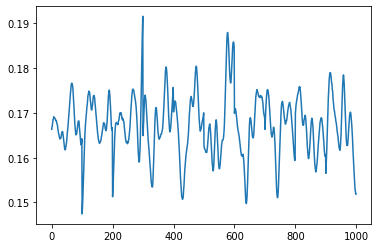

In [60]:
plt.plot(SigGen[4])

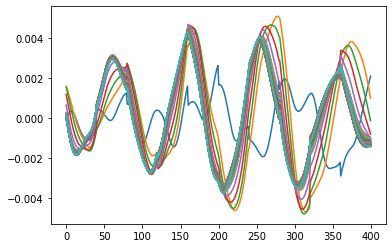

In [37]:
for i in range(N_Exp):
    plt.plot(Pred[2][i])

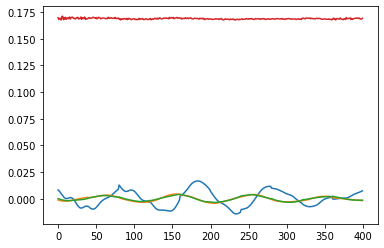

In [17]:
for i in range(4):
    plt.plot(Pred[i][2])

In [153]:
TotalLayers = SigBandRepModel.layers
print(len(TotalLayers))

TotalLayers, Tr_EncoderLayers = LayerExtractor(TotalLayers, EncoderLayers)
print(len(Tr_EncoderLayers), len(EncoderLayers))

TotalLayers, Tr_FeatExtLayers = LayerExtractor(TotalLayers, Enc2FeatExtLayers)
print(len(Tr_FeatExtLayers), len(Enc2FeatExtLayers))

TotalLayers, Tr_FeatGenLayers = LayerExtractor(TotalLayers, Enc2FeatGenLayers)
print(len(Tr_FeatGenLayers), len(Enc2FeatGenLayers))

257
14 26
57 121
27 69


In [ ]:
FeatGenOut = FeatGenerator([EncOut[1],EncOut[2][:, :2], EncOut[2][:, 2:]])


In [ ]:
### Define total model again
ModelInp, Z_Mean = Encoder()
LatGenOut = Decoder(Z_Mean[0])
LatGenOut = ReName(LatGenOut, 'Out')
SigGenModel = Model(ModelInp[0], LatGenOut)
SigGenModel.load_weights(ModelSaveSameName)

### Load trained layers
EncoderLayers = Model(ModelInp, Z_Mean).layers
DecoderStartIDX = len(EncoderLayers)
DecoderLayers = SigGenModel.layers[DecoderStartIDX:]


### Define a sub-model
New_DecInp = Input((2,))
New_DecOut = Decoder(New_DecInp)
New_DecModel = Model(New_DecInp, New_DecOut)

### Weight update
DecoderLayersWeights = []
for i in DecoderLayers:
    DecoderLayersWeights.extend(i.get_weights())
    
New_DecModel.set_weights(DecoderLayersWeights)